#### Import libs

In [2]:
import torch
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

#### Make Regression

In [4]:
def make_y(x, rand_impact = 1e-1):
    return 2 * x + 3 + rand_impact * np.random.randn(*x.shape)

In [5]:
X = np.arange(-10, 20).reshape((-1, 1))

In [6]:
y = make_y(X, 4).reshape((-1, 1))

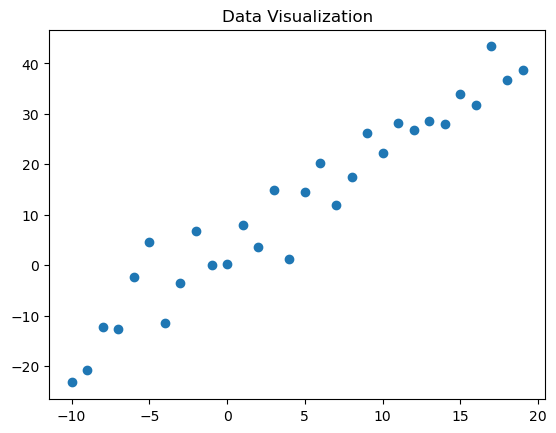

In [7]:
plt.scatter(X, y);
plt.title('Data Visualization')
plt.show()

In [13]:
X.shape, y.shape

((30, 1), (30, 1))

In [15]:
class MyModel:
    def __init__(self, num_features, lr = 1e-4, reg_l1 = 0):
        self.w = np.random.randn(num_features, 1)
        self.b = np.random.rand()
        self.lr = lr
        self.reg = reg_l1

    def forward(self, x):
        return x @ self.w + self.b


    def backward(self, x, y_true, y_preds = None):
        if y_preds.all() == None:
            y_preds = self.forward(x)
        if y_preds.shape != y_true.shape:
            raise ValueError("Different shapes of y_true and y_pred")
        self.w -= (- 2 * self.lr * x.T @ (y_true - y_preds)) / len(y_true) + self.reg * np.sign(self.w)
        self.b += 2 * self.lr * np.sum((y_true - y_preds)) / len(y_true)

In [17]:
model = MyModel(1, lr=1e-4, reg_l1=1e-4)

In [19]:
def MSE(y_true, y_preds):
    return np.sum(np.power(y_true - y_preds, 2))

In [21]:
def train_model(model, x_train, y_train, loss_fn, num_epochs = 1000):
    for epoch in range(num_epochs):
        y_preds = model.forward(x_train)
        model.backward(x_train, y_train, y_preds)
        loss = loss_fn(y_train, y_preds)
        if epoch % 1000 == 0:
            print(f"Epoch: {epoch}\tloss:{loss}")

In [23]:
train_model(model, X, y, MSE, 2000)

Epoch: 0	loss:20927.047925154435
Epoch: 1000	loss:767.5762019568549


In [25]:
preds = model.forward(X)

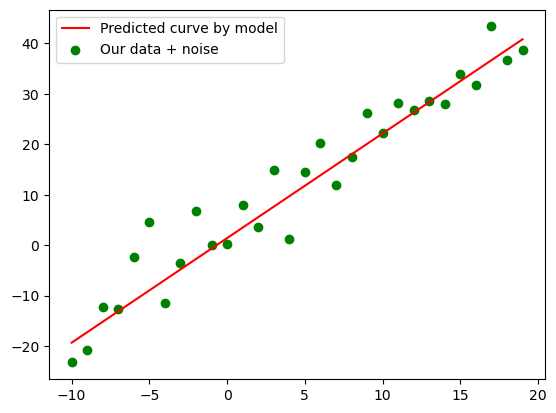

In [27]:
plt.plot(X, preds, color="red", label="Predicted curve by model")
plt.scatter(X, y, color='green', label='Our data + noise')
plt.legend()
plt.show()

In [29]:
def make_y_without_noise(x, rand_impact = 1e-1):
    return 2 * x + 3

In [31]:
y = make_y_without_noise(X, 4).reshape((-1, 1))

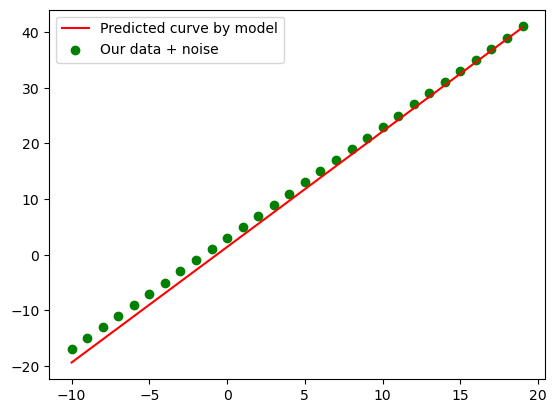

In [33]:
plt.plot(X, preds, color="red", label="Predicted curve by model")
plt.scatter(X, y, color='green', label='Our data + noise')
plt.legend()
plt.show()

In [35]:
model = MyModel(1, lr=1e-4, reg_l1=1e-4)

In [37]:
train_model(model, X, y, MSE, 6000)

Epoch: 0	loss:33196.29005445549
Epoch: 1000	loss:106.21482786681467
Epoch: 2000	loss:77.22110151982582
Epoch: 3000	loss:56.10047734443829
Epoch: 4000	loss:40.722062359380395
Epoch: 5000	loss:29.530688460593367


In [39]:
preds = model.forward(X)

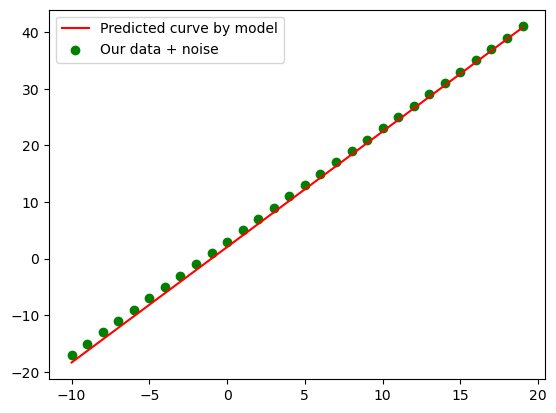

In [41]:
plt.plot(X, preds, color="red", label="Predicted curve by model")
plt.scatter(X, y, color='green', label='Our data + noise')
plt.legend()
plt.show()

#### Make classification

In [1621]:
X, y = make_blobs(centers=2, cluster_std=1)

In [1623]:
X.shape, y.shape

((100, 2), (100,))

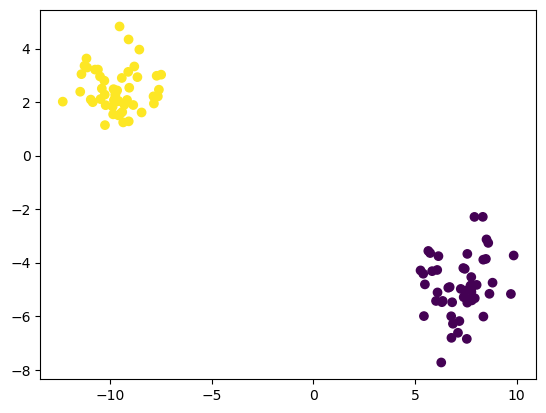

In [1625]:
plt.scatter(X[:, 0], X[:, 1], c=y);

In [1627]:
y = y[:, None]

In [1629]:
y = np.eye(len(np.unique(y)))[y].squeeze()

In [1631]:
y.shape

(100, 2)

In [1633]:
y = y.astype(int)

In [1903]:
class ClassificationModel:
    def __init__(self, num_features = 2, hidden_features = 2 , num_classes = 2, lr = 1e-4, reg = 0):
        self.w0 = 0.01 * np.random.randn(num_features, hidden_features)
        self.b0 = np.zeros((1, hidden_features))
        self.w1 = 0.01 * np.random.randn(hidden_features, num_classes)
        self.b1 = np.zeros((1, num_classes))
        self.lr = lr
        self.reg = reg

    def ReLU(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        x -= np.max(x, axis = 1, keepdims=True)
        return np.exp(x) / np.sum(np.exp(x), axis = 1, keepdims= True)
    
    def forward(self, x): # N x 2
        x = self.ReLU(x @ self.w0 + self.b0) # -> N x 3
        return self.softmax(x @ self.w1 + self.b1) # -> N x 2


    def backward(self, x, y_true, y_pred = None):
        if y_true.shape != y_pred.shape:
            raise ValueError("Wrong shapes of y_true and y_pred")
        dprobs = y_pred.copy()
        dprobs[:, y_true] -= 1 # N x 1
        dprobs /= len(y_true)
        
        x1 = np.where(x @ self.w0 + self.b0 > 0, 1, 0) # -> N x 3
        
        dw1 = x1.T @ dprobs  # -> 3 x 1
        dw1 += self.reg * self.w1
        db1 = np.sum(dprobs, axis=0, keepdims=True) # -> 1 x 1
        
        drelu = (dprobs @ self.w1.T) * x1 # N x 3
        
        dw0 = x.T @ drelu
        dw0 += self.reg * self.w0
        db0 = np.sum(drelu, axis=0, keepdims=True)

        self.w1 -= self.lr * dw1
        self.b1 -= self.lr * db1
        self.w0 -= self.lr * dw0
        self.b0 -= self.lr * db0

In [2015]:
model = ClassificationModel(hidden_features=2, reg = 0)

In [2017]:
def bce_loss(y_true, y_preds):
    return - np.sum(y_true * np.log(y_preds)) / len(y_true)

In [2109]:
model.lr = 3e-5

In [2111]:
train_model(model, X, y, bce_loss, 20000)

Epoch: 0	loss:0.6931459069395092
Epoch: 1000	loss:0.6931459067258956
Epoch: 2000	loss:0.6931459065394983
Epoch: 3000	loss:0.6931459063766207
Epoch: 4000	loss:0.6931459062364691
Epoch: 5000	loss:0.6931459061124718
Epoch: 6000	loss:0.6931459060104698
Epoch: 7000	loss:0.6931459059365921
Epoch: 8000	loss:0.6931459058826348
Epoch: 9000	loss:0.693145905855936
Epoch: 10000	loss:0.6931459058468815
Epoch: 11000	loss:0.6931459058537149
Epoch: 12000	loss:0.6931459058884036
Epoch: 13000	loss:0.6931459059384599
Epoch: 14000	loss:0.6931459060075247
Epoch: 15000	loss:0.6931459061018499
Epoch: 16000	loss:0.6931459062167431
Epoch: 17000	loss:0.6931459063508671
Epoch: 18000	loss:0.6931459065062304
Epoch: 19000	loss:0.6931459066755253


In [2112]:
f"{np.sum(np.argmax(model.forward(X), axis=1) == np.argmax(y, axis=1)) / len(y) * 100}%"

'79.0%'

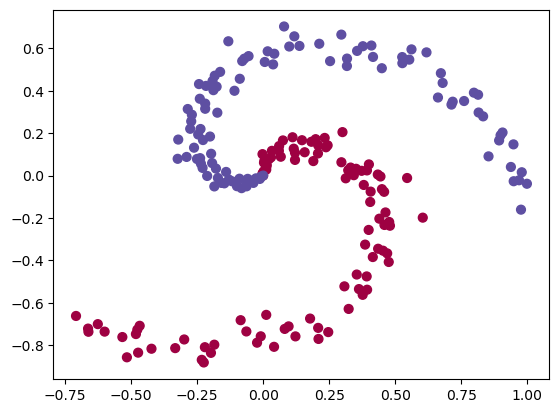

In [2113]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 2 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [2117]:
y = np.eye(len(np.unique(y)))[y].squeeze()

In [2119]:
y.shape

(200, 2)

In [2121]:
y = y.astype(int)

In [2123]:
model = ClassificationModel(hidden_features=100, reg= 1e-5)

In [2125]:
def bce_loss(y_true, y_preds):
    return - np.sum(y_true * np.log(y_preds)) / len(y_true)

In [2127]:
model.lr = 1e-5

In [2149]:
train_model(model, X, y, bce_loss, 20000)

Epoch: 0	loss:0.6928433616331005
Epoch: 1000	loss:0.6928431771667181
Epoch: 2000	loss:0.6928430054622163
Epoch: 3000	loss:0.6928428458656295
Epoch: 4000	loss:0.692842697720865
Epoch: 5000	loss:0.6928425603752055
Epoch: 6000	loss:0.6928424331841554
Epoch: 7000	loss:0.692842315515623
Epoch: 8000	loss:0.6928422067534931
Epoch: 9000	loss:0.6928421063005878
Epoch: 10000	loss:0.6928420135810873
Epoch: 11000	loss:0.6928419280424306
Epoch: 12000	loss:0.6928418491567493
Epoch: 13000	loss:0.6928417764218864
Epoch: 14000	loss:0.6928417093620284
Epoch: 15000	loss:0.692841647528022
Epoch: 16000	loss:0.6928415904973884
Epoch: 17000	loss:0.6928415378740964
Epoch: 18000	loss:0.692841489288125
Epoch: 19000	loss:0.6928414443948447


In [2150]:
f"{np.sum(np.argmax(model.forward(X), axis=1) == np.argmax(y, axis=1)) / len(y) * 100}%"

'78.5%'

#### Visualize

In [2154]:
correct = (np.argmax(y, axis = 1) == np.argmax(model.forward(X), axis = 1)).astype(int)

In [2156]:
correct

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

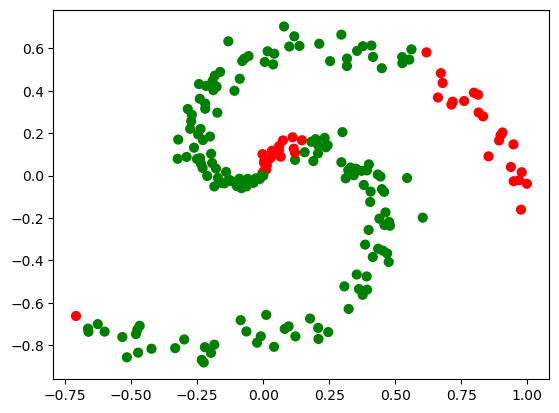

In [2158]:
plt.scatter(X[:, 0], X[:, 1], c=np.where(correct == 0, 'red', 'green'), s=40)
plt.show()

#### Сделаем то же самое, но используя PyTorch

In [2161]:
import torch.nn as nn

In [2177]:
class RegressionModel(nn.Module):
    def __init__(self, in_features = 2):
        super().__init__()
        self.w = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.w(x)

In [2179]:
def MSE(y_true, y_preds):
    return torch.sum(torch.pow(y_true - y_preds, 2))

In [2433]:
def train_torch(model, x_train, y_train, loss_fn, epochs):
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
    for epoch in range(epochs):
        optimizer.zero_grad()
        preds = model(x_train)
        loss = loss_fn(y_train, preds)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch: {epoch}\tloss:{loss}")

In [2435]:
model = RegressionModel(1)

In [2437]:
X = np.arange(-10, 20).reshape((-1, 1)).astype(np.float32)

In [2439]:
y = make_y(X, 4).reshape((-1, 1))

In [2441]:
X = torch.tensor(X)
y = torch.tensor(y)

In [2443]:
train_torch(model, X, y, MSE, 1000)

Epoch: 0	loss:9069.874070161552


In [2445]:
preds = model(X).detach().numpy()

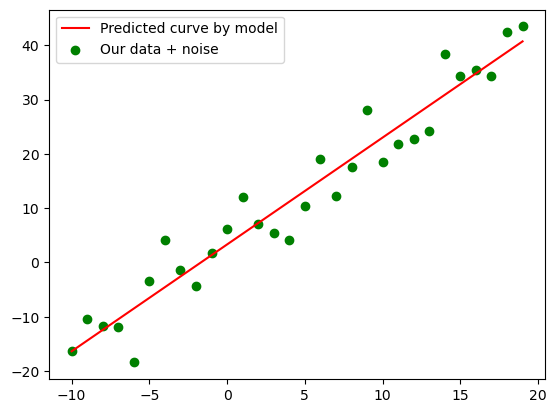

In [2447]:
plt.plot(X, preds, color="red", label="Predicted curve by model")
plt.scatter(X, y, color='green', label='Our data + noise')
plt.legend()
plt.show()

In [2449]:
X, y = make_blobs(centers=2, cluster_std=1)

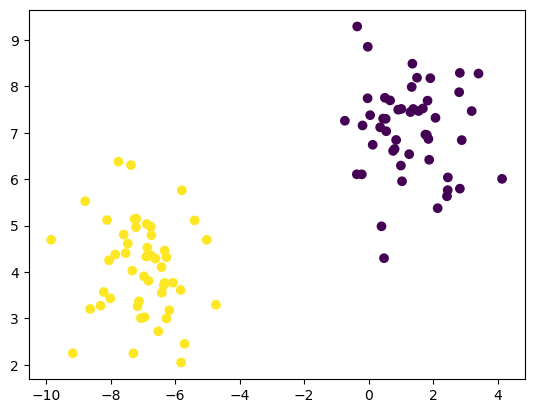

In [2451]:
plt.scatter(X[:, 0], X[:, 1], c=y);

In [2453]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y)

In [2455]:
y = torch.eye(len(y.unique()))[y]

In [2457]:
X.shape, y.shape

(torch.Size([100, 2]), torch.Size([100, 2]))

In [2459]:
class LogisticRegression(nn.Module):
    def __init__(self, num_features = 2, hidden = 2, out_features = 2):
        super().__init__()
        self.fc1 = nn.Linear(num_features, hidden)
        self.act1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hidden, out_features)
        self.sm = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return self.sm(x)

In [2461]:
model = LogisticRegression(hidden = 4)

In [2463]:
def CE(y_true, y_preds):
    return -torch.sum(y_true * torch.log(y_preds)) / len(y_true)

In [2465]:
train_torch(model, X, y, CE, 10000)

Epoch: 0	loss:0.7860283851623535
Epoch: 1000	loss:0.5443534851074219
Epoch: 2000	loss:0.4675154387950897
Epoch: 3000	loss:0.41357749700546265
Epoch: 4000	loss:0.3638301491737366
Epoch: 5000	loss:0.3157256245613098
Epoch: 6000	loss:0.2698855698108673
Epoch: 7000	loss:0.22784779965877533
Epoch: 8000	loss:0.19095094501972198
Epoch: 9000	loss:0.15976981818675995


In [2473]:
f"{(torch.argmax(model(X), dim=1) == torch.argmax(y, dim=1)).sum().item() / len(y) * 100}%"

'100.0%'